## Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Dataset

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [3]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

# Transformer Block

In [4]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Tokenizing with Positional Encodings

In [18]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Hyper-parameters

In [19]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# Model

In [20]:
inputs = layers.Input(shape=(maxlen,))

embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [21]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 token_and_position_embedding_2  (None, 200, 32)     646400      ['input_3[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 transformer_block_2 (Transform  (None, 200, 32)     10656       ['token_and_position_embedding_2[
 erBlock)                                                        0][0]',                          
                                                                  'transformer_block_2[0][0]

In [23]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val)
)

Epoch 1/10
782/782 [==============================] - 16s 17ms/step - loss: 0.3886 - accuracy: 0.8131 - val_loss: 0.2946 - val_accuracy: 0.8752
Epoch 2/10
782/782 [==============================] - 13s 17ms/step - loss: 0.1880 - accuracy: 0.9295 - val_loss: 0.3142 - val_accuracy: 0.8699
Epoch 3/10
782/782 [==============================] - 13s 17ms/step - loss: 0.1050 - accuracy: 0.9649 - val_loss: 0.4184 - val_accuracy: 0.8598
Epoch 4/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0550 - accuracy: 0.9819 - val_loss: 0.5032 - val_accuracy: 0.8496
Epoch 5/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0315 - accuracy: 0.9900 - val_loss: 0.6141 - val_accuracy: 0.8471
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.6845 - val_accuracy: 0.8381
Epoch 7/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.7458 - val_accuracy:

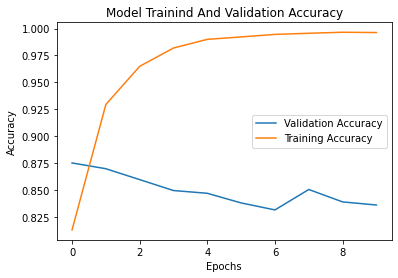

In [24]:
import matplotlib.pyplot as plt

epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(epochs, history.history['accuracy'], label = 'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Model Trainind And Validation Accuracy")
plt.legend()

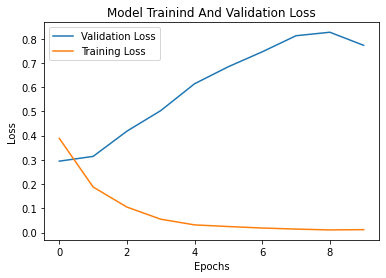

In [25]:
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['val_loss'], label = 'Validation Loss')
plt.plot(epochs, history.history['loss'], label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Model Trainind And Validation Loss")
plt.legend()

#Implemented by Muhammad Hanan Asghar